In [1]:
import fastai
import scipy
scipy.__version__, fastai.__version__

('1.7.3', '2.7.5')

In [2]:
#|export
from __future__ import annotations
from fastai.basics import *
from fastai.tabular.core import *
from fastai.tabular.model import *
from fastai.tabular.data import *
from fastai.tabular.all import *

/home/fabio/Documents/tabular_lesion/env_tabular/lib/python3.8/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


In [3]:
!pwd

/home/fabio/Documents/tabular_lesion


In [4]:
data_path = os.path.join(os.getcwd(), 'data')
data_path

'/home/fabio/Documents/tabular_lesion/data'

In [5]:
import os

import pandas as pd
import sklearn
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, log_loss

from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline, FeatureUnion

from helpers.dataset import DataSet
from helpers.variance import DataVariance
from helpers.roc_curve import RocCurve
from helpers.validation import ModelValidation
from helpers.model_save import XgboostModelToOnnx

from bayes_opt import BayesianOptimization

In [7]:
all_set = DataSet(os.path.join(data_path, 'lesion_df_balanced_Target_Lesion_ClinSig.csv'))

Are there any Nan = False, Number of Nan = 0
Target_Lesion_ClinSig


In [8]:
all_set.X_train.shape

(33764, 105)

In [9]:
df = pd.concat([all_set.X_train, all_set.y_train], axis=1)
df.head()

,Feature_1,Feature_2,Feature_3,Feature_8,Feature_9,Feature_10,Feature_11,Feature_21,Feature_22,Feature_23,...,Feature_124,Feature_125,Feature_126,Feature_127,Feature_128,Feature_129,Feature_130,Feature_131,Feature_132,Target_Lesion_ClinSig
0,0.0,0.0,-1.0,0.0,-0.429758,-0.868126,1.0,0.429758,0.495042,1.0,...,9.211581,-0.226057,55.650623,14.544326,9.033076,-0.274966,55.650623,13.88554,9.141769,1
1,0.0,0.0,-1.0,0.0,-0.429758,-0.868126,1.0,0.429758,0.495042,1.0,...,9.211581,-0.226057,55.650623,14.544326,9.033076,-0.274966,55.650623,13.88554,9.141769,1
2,0.0,0.0,-1.0,0.0,-0.429758,-0.868126,1.0,0.429758,0.495042,1.0,...,9.211581,-0.226057,55.650623,14.544326,9.033076,-0.274966,55.650623,13.88554,9.141769,1
3,0.0,0.0,-1.0,0.0,-0.429758,-0.868126,1.0,0.429758,0.495042,1.0,...,9.211581,-0.226057,55.650623,14.544326,9.033076,-0.274966,55.650623,13.88554,9.141769,1
4,0.0,0.0,-1.0,0.0,-0.429758,-0.868126,1.0,0.429758,0.495042,1.0,...,9.211581,-0.226057,55.650623,14.544326,9.033076,-0.274966,55.650623,13.88554,9.141769,1


In [10]:
cat_names = None
cont_names = list(all_set.X_train.columns)

In [11]:
splits = RandomSplitter(valid_pct=0.2)(range_of(df))
procs = [Categorify, FillMissing, Normalize]
to = TabularPandas(df, procs=procs,
                   # cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='Target_Lesion_ClinSig',
                   y_block = CategoryBlock(),
                   splits=splits)

trn_dl = TabDataLoader(to.train, bs=64, shuffle=True, drop_last=True)
val_dl = TabDataLoader(to.valid, bs=128)

dls = DataLoaders(trn_dl, val_dl)
# dls.show_batch()

In [56]:
def fit_with(lr:float, wd:float, dp:float, n_layers:float, layer_1:float, layer_2:float, layer_3:float):

    print(lr, wd, dp)
    if round(n_layers) == 2:
        layers = [round(layer_1), round(layer_2)]
    elif int(n_layers) == 3:
        layers = [round(layer_1), round(layer_2), round(layer_3)]
    else:
        layers = [round(layer_1)]
        
    config = tabular_config(embed_p=float(dp), ps=float(wd))
    
    learn = tabular_learner(dls, layers=layers, metrics=F1Score(), config = config)

    with learn.no_bar() and learn.no_logging():
        learn.fit(5, lr=float(lr))

    acc = float(learn.validate()[1])

    return acc

In [57]:
hps = {'lr': (1e-05, 1e-01),
      'wd': (4e-4, 0.4),
      'dp': (0.01, 0.5),
       'n_layers': (1,3),
       'layer_1': (50, 200),
       'layer_2': (100, 1000),
       'layer_3': (200, 2000)}

In [58]:
optim = BayesianOptimization(
    f = fit_with, # our fit function
    pbounds = hps, # our hyper parameters to tune
    verbose = 2, # 1 prints out when a maximum is observed, 0 for silent
    random_state=2022
)

In [59]:
%time optim.maximize(n_iter=10)

|   iter    |  target   |    dp     |  layer_1  |  layer_2  |  layer_3  |    lr     | n_layers  |    wd     |
-------------------------------------------------------------------------------------------------------------
0.06854390534836674 0.35910382768673055 0.014585720765804704


|  1        |  0.9543   |  0.01459  |  124.9    |  202.0    |  290.0    |  0.06854  |  1.974    |  0.3591   |
0.08275853120149226 0.38283491653085705 0.3272515146642005


|  2        |  0.9549   |  0.3273   |  184.5    |  749.0    |  1.696e+0 |  0.08276  |  2.667    |  0.3828   |
0.09775318854574432 0.2977848024169444 0.19034177413244452


|  3        |  0.9191   |  0.1903   |  124.2    |  405.6    |  1.315e+0 |  0.09775  |  1.193    |  0.2978   |
0.0523785062241329 0.15578159896948549 0.15332474230673704


|  4        |  0.9517   |  0.1533   |  94.8     |  777.2    |  233.6    |  0.05238  |  2.729    |  0.1558   |
0.09759110360848654 0.31779016667245213 0.11397400623877652


|  5        |  0.9145   |  0.114    |  121.3    |  608.2    |  829.0    |  0.09759  |  1.076    |  0.3178   |
0.014758066187534273 0.05187424191487874 0.0706900595359896


|  6        |  0.9753   |  0.07069  |  152.5    |  807.6    |  1.622e+0 |  0.01476  |  2.988    |  0.05187  |
0.06153371553831089 0.2914475542763275 0.48120741011414464


|  7        |  0.9695   |  0.4812   |  155.8    |  794.3    |  1.624e+0 |  0.06153  |  1.874    |  0.2914   |
0.0049353990128066065 0.3128612876006826 0.36478073734354854


|  8        |  0.9754   |  0.3648   |  107.6    |  779.1    |  232.7    |  0.004935 |  2.796    |  0.3129   |
0.0848487986269036 0.25788393868333537 0.4476694232634263


|  9        |  0.8881   |  0.4477   |  126.3    |  791.2    |  230.1    |  0.08485  |  2.707    |  0.2579   |
0.07701337489203235 0.2593419629074263 0.17453061533217995


|  10       |  0.9493   |  0.1745   |  155.4    |  799.6    |  1.639e+0 |  0.07701  |  1.174    |  0.2593   |
0.04269487123289349 0.006238360333659032 0.3077286615541998


|  11       |  0.9792   |  0.3077   |  125.3    |  197.5    |  287.5    |  0.04269  |  1.66     |  0.006238 |
0.09990176105563875 0.09339602098834633 0.367982640391549


|  12       |  0.9642   |  0.368    |  158.0    |  804.3    |  1.626e+0 |  0.0999   |  1.118    |  0.0934   |
0.014634903700777328 0.3430530409953527 0.23157593758487263


|  13       |  0.9742   |  0.2316   |  154.7    |  806.8    |  1.608e+0 |  0.01463  |  1.112    |  0.3431   |
0.05905229493959001 0.11848337739111885 0.30704556465167204


|  14       |  0.8994   |  0.307    |  149.9    |  822.6    |  1.619e+0 |  0.05905  |  2.805    |  0.1185   |
0.024039443585879866 0.040885786419594526 0.2555671237620613


|  15       |  0.9742   |  0.2556   |  150.3    |  801.4    |  1.597e+0 |  0.02404  |  1.458    |  0.04089  |
CPU times: user 12min 24s, sys: 8.74 s, total: 12min 33s
Wall time: 3min 6s


In [60]:
print(optim.max)

{'target': 0.9792446410343655, 'params': {'dp': 0.3077286615541998, 'layer_1': 125.30464227323006, 'layer_2': 197.4724508662511, 'layer_3': 287.51004157972625, 'lr': 0.04269487123289349, 'n_layers': 1.6602770901706678, 'wd': 0.006238360333659032}}


In [61]:
opt = optim.max["params"]
layers = []

for i in range(0,int(optim.max["params"]["n_layers"])):
    selector = "layer_" + str(i+1)
    layers.append(int(opt[selector]))

In [69]:
optmized_config = tabular_config(embed_p=float(opt['dp']), ps=float(opt['wd']))

In [72]:
optmized_learn = tabular_learner(dls, layers=layers, opt_func=RAdam, config=optmized_config,
                                 metrics=[accuracy, error_rate, RocAucBinary(), Recall(), Precision(), F1Score()])

In [73]:
optmized_learn.fit(25, lr=float(opt["lr"]), cbs=[EarlyStoppingCallback(monitor='accuracy', min_delta=0.01, patience=2)])

epoch,train_loss,valid_loss,accuracy,error_rate,roc_auc_score,recall_score,precision_score,f1_score,time
0,0.098123,0.058238,0.979265,0.020735,0.997018,0.939271,0.965326,0.952120,00:02
1,0.073638,0.068013,0.981783,0.018217,0.997881,0.989879,0.931429,0.959764,00:02
2,0.055543,0.041533,0.984153,0.015847,0.998816,0.988529,0.942122,0.964768,00:02


No improvement since epoch 0: early stopping


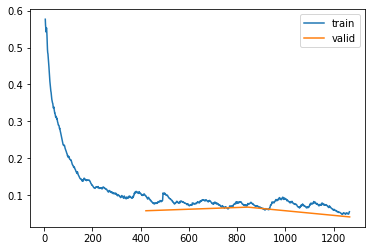

In [74]:
optmized_learn.recorder.plot_loss()

In [75]:
dl_test = pd.concat([all_set.X_test, all_set.y_test], axis=1)

In [77]:
to_a = optmized_learn.dls.train_ds.new(dl_test)
to_a.process()
dl_a = TabDataLoader(to_a)

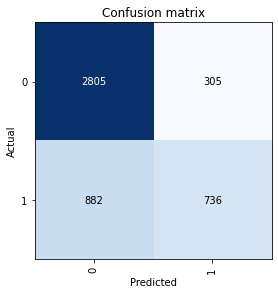

In [79]:
interp = ClassificationInterpretation.from_learner(optmized_learn, dl=dl_a)
interp.plot_confusion_matrix()

In [80]:
interp.print_classification_report()

              precision    recall  f1-score   support

           0       0.76      0.90      0.83      3110
           1       0.71      0.45      0.55      1618

    accuracy                           0.75      4728
   macro avg       0.73      0.68      0.69      4728
weighted avg       0.74      0.75      0.73      4728



In [ ]:
interp.print_classification_report()

In [84]:
preds,y, loss = optmized_learn.get_preds(dl=dl_a, with_loss=True)
# get accuracy
acc = accuracy(preds, y)
print(f'The accuracy is {acc:0.3f}%.')

The accuracy is 0.749%.


In [82]:
from sklearn.metrics import roc_curve, auc
# probs from log preds
probs = np.exp(preds[:,1])
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)

# Compute ROC area
roc_auc = auc(fpr, tpr)
print('ROC area is {0}'.format(roc_auc))

ROC area is 0.7156721608591449


In [85]:
import plotly.express as px

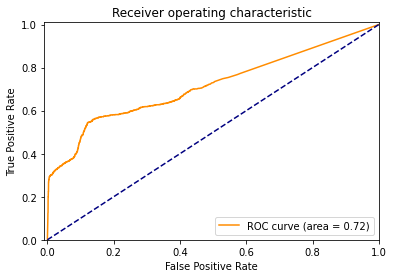

In [83]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

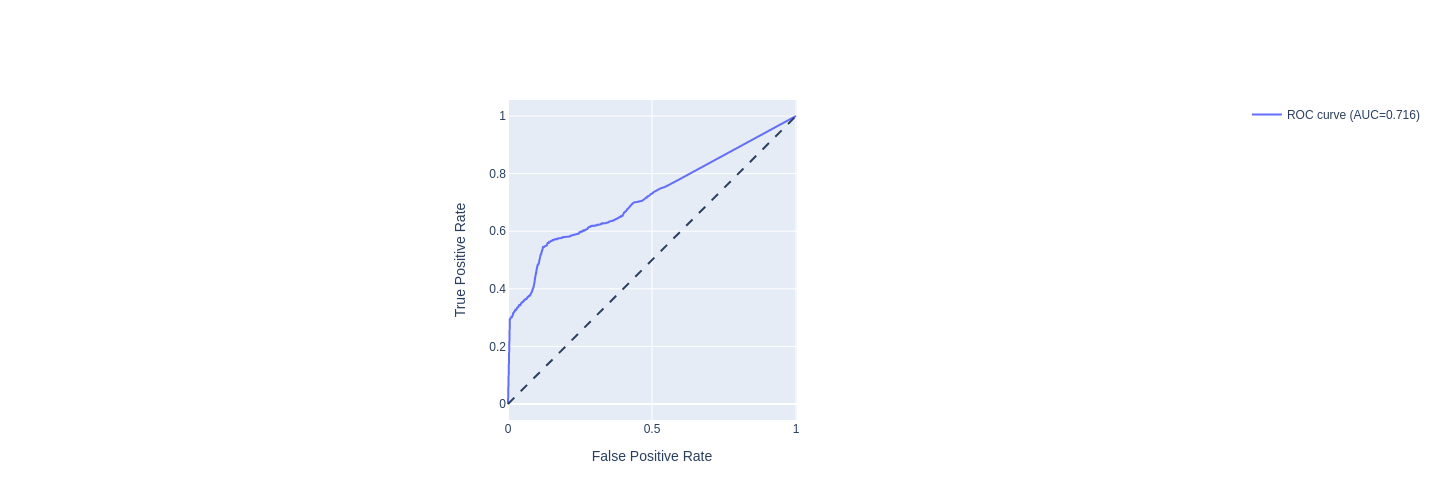

In [90]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)
# name = f"ROC Train (AUC={roc['train'][2]:.3f})"
# fig.add_trace(go.Scatter(x=roc['train'][0], y=roc['train'][1], name=name, mode='lines'))

name = f"ROC curve (AUC={roc_auc:.3f})"
fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'))

fig.update_layout(
    uniformtext_minsize=12,
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis=dict(constrain='domain'),
    width=700, height=500,
    showlegend=True
)
fig.show()

In [92]:
to = optmized_learn.dls.train_ds.new(dl_test[:100])
to.process()
dl = TabDataLoader(to)

In [93]:
# !pip install fastinference[all]
import fastinference
from fastinference.tabular import *

In [95]:
exp = ShapInterpretation(optmized_learn, dl_a)

  0%|          | 0/4728 [00:00<?, ?it/s]

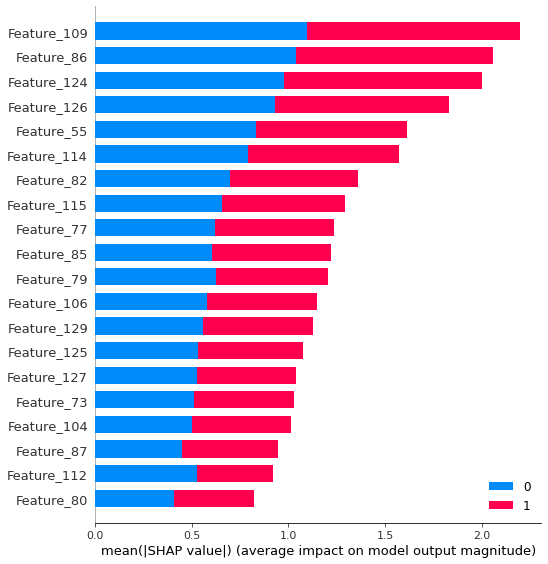

In [96]:
exp.summary_plot()

Classification model detected, displaying score for the class 1.
(use `class_id` to specify another class)
Displaying row 10 of 100 (use `row_idx` to specify another row)


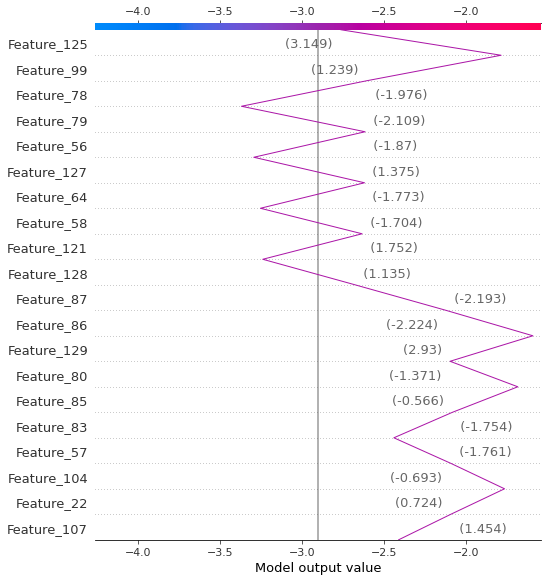

In [22]:
exp.decision_plot(class_id=1, row_idx=10)